# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [90]:
# Imports
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from umap import UMAP
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

%load_ext autoreload
%autoreload 2

# Set seeds for reproducibility
seed_value = 42
tf.keras.utils.set_random_seed(seed_value) 
tf.config.experimental.enable_op_determinism()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [123]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

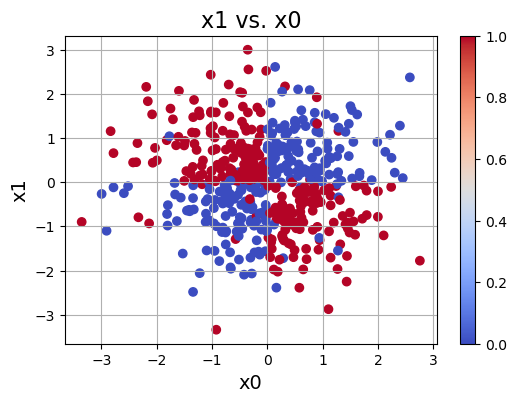

In [124]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

In [125]:
# Hyperparameters for neural network
neurons = 10

# Neural network architecture
model = Sequential()
model.add(Input(shape=(2,)))
model.add(Dense(neurons, activation='relu'))
model.add(Dense(neurons, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Hyperparameters for the learning rate scheduler
warmup_steps = 100
initial_learning_rate = 0.01
decay_steps = 1000

# Learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
)

# Learning rate scheduler with warmup and cosine decay
class WarmupThenCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_schedule, warmup_steps, initial_learning_rate):
        self.lr_schedule = lr_schedule
        self.warmup_steps = warmup_steps
        self.initial_learning_rate = initial_learning_rate
    
    def __call__(self, step):
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: self.lr_schedule(step - self.warmup_steps)
        )

final_lr_schedule = WarmupThenCosineDecay(lr_schedule, warmup_steps, initial_learning_rate)

# Compile the model with the scheduled learning rate
optimizer = Adam(learning_rate=final_lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train[['x0', 'x1']], train['y'], epochs=500, verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(test[['x0', 'x1']], test['y'])
print(f'Accuracy: {accuracy:.2f}')

KeyboardInterrupt: 

In [ ]:
class WarmupThenCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, lr_schedule, warmup_steps, initial_learning_rate):
        self.lr_schedule = lr_schedule
        self.warmup_steps = warmup_steps
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        warmup_lr = self.initial_learning_rate * (step / self.warmup_steps)
        return tf.cond(
            step < self.warmup_steps,
            lambda: warmup_lr,
            lambda: self.lr_schedule(step - self.warmup_steps)
        )
        
# Define a model creation function for KerasClassifier
def create_model(warmup_steps=100, lr=0.01, decay_steps=100):
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
        initial_learning_rate=lr,
        decay_steps=decay_steps,
    )
    final_lr_schedule = WarmupThenCosineDecay(lr_schedule, warmup_steps, lr)
    
    optimizer = Adam(learning_rate=final_lr_schedule)
    
    # Neural network architecture
    model = Sequential()
    model.add(Dense(neurons, input_dim=2, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Wrap the Keras model with KerasClassifier, and stop early if no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model = KerasClassifier(
    model=create_model,
    verbose=0,
    callbacks=[early_stopping]
)

# Define the hyperparameter grid
param_grid = {
    'model__warmup_steps': [100],
    'model__lr': [0.01, 0.001],
    'model__decay_steps': [100, 1000],
    'epochs': [50, 100]
}

# Use GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(
    train[['x0', 'x1']], train['y'],
    validation_split=0.2
)

# Summarize the results
print(f'Best accuracy: {grid_result.best_score_:.2f}')
print(f'Best hyperparameters: {grid_result.best_params_}')

# Evaluate the best model
best_model = grid_result.best_estimator_
test_accuracy = best_model.score(test[['x0', 'x1']], test['y'])
print(f'Accuracy on test data: {test_accuracy:.2f}')

c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs

Best accuracy: 0.92
Best hyperparameters: {'epochs': 100, 'model__decay_steps': 1000, 'model__lr': 0.01, 'model__warmup_steps': 100}
Accuracy on test data: 0.91


In [ ]:
# Saving best hyperparameters manually from the resulst above:
best_hyperparameters = {
    'warmup_steps': 100,
    'initial_learning_rate': 0.1,
    'decay_steps': 1000,
    'epochs': 100
}

In [ ]:
# Train the model with the best hyperparameters
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=grid_result.best_params_['model__lr'],
    decay_steps=grid_result.best_params_['model__decay_steps'],
)

# Neural network architecture
model = Sequential()
model.add(Dense(neurons, input_dim=2, activation='relu'))
model.add(Dense(neurons, activation='relu'))
model.add(Dense(neurons, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model_wo_scheduler = Sequential()
model_wo_scheduler.add(Dense(neurons, input_dim=2, activation='relu'))
model_wo_scheduler.add(Dense(neurons, activation='relu'))
model_wo_scheduler.add(Dense(neurons, activation='relu'))
model_wo_scheduler.add(Dense(1, activation='sigmoid'))

final_lr_schedule = WarmupThenCosineDecay(lr_schedule, grid_result.best_params_["model__warmup_steps"], grid_result.best_params_['model__lr'])
optimizer = Adam(learning_rate=final_lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model_wo_scheduler.compile(optimizer=Adam(learning_rate=grid_result.best_params_['model__lr']), loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)
model_wo_scheduler.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)

# Evaluate the model
loss, accuracy = model.evaluate(test[['x0', 'x1']], test['y'])
loss_wo_scheduler, accuracy_wo_scheduler = model_wo_scheduler.evaluate(test[['x0', 'x1']], test['y'])
print(f'Accuracy: {accuracy:.2f}')
print(f'Accuracy without scheduler: {accuracy_wo_scheduler:.2f}')

c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9100 - loss: 0.2741
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9020 - loss: 0.2660
Accuracy: 0.91
Accuracy without scheduler: 0.90


Discussion

Reproducibility of Results  

To ensure reproducibility, I set a fixed random seed so the model would consistently converge to the same local minima and produce identical scores across runs. This allows performance changes to reflect real improvements rather than randomness. I also enabled enable_op_determinism() in TensorFlow to enforce deterministic operations. Despite these efforts, full determinism was not achieved, so the results remain largely, but not entirely reproducible.

Choosing the Optimizer

I chose the Adam optimizer due to its proven effectiveness across a wide range of use cases. Adam (Adaptive Moment Estimation) extends stochastic gradient descent (SGD) by maintaining moving averages of both the gradients and their squared values. While this introduces slightly more computation, it significantly improves convergence speed and stability. Compared to SGD, Adam is more resilient to suboptimal hyperparameters and less sensitive to the initial learning rate, reducing the need for extensive manual tuning. This robustness makes it a practical and efficient choice for most neural network training tasks.

Learning Rate Scheduling

The learning rate schedule, illustrated later, improved model performance during final training. This improvement is largely attributed to the cosine decay and warmup phases. The cosine decay gradually reduces the learning rate over time, guiding the optimizer toward a different and often better local minimum than a constant learning rate would. The warmup phase helps stabilize the early stages of training, preventing large or erratic weight updates. Together, these mechanisms allow the model to explore the parameter space broadly at first and then fine-tune more precisely as training progresses, resulting in smoother convergence and improved overall performance.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


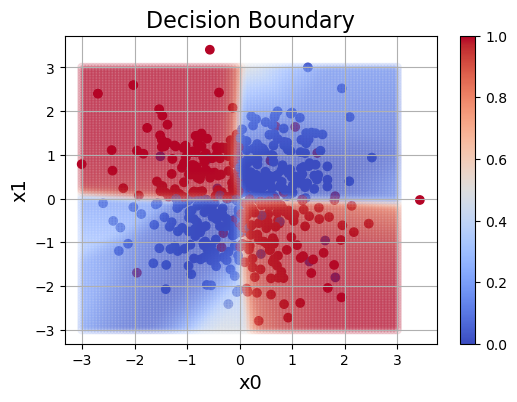

In [ ]:
# Visualize decision boundary
plt.figure(figsize=(6, 4))
plt.scatter(test['x0'], test['x1'], c=test['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('Decision Boundary', fontsize=16)
plt.colorbar()

# Create a meshgrid
x0_values = np.linspace(-3, 3, 100)
x1_values = np.linspace(-3, 3, 100)
x0_mesh, x1_mesh = np.meshgrid(x0_values, x1_values)
x0_mesh = x0_mesh.flatten()
x1_mesh = x1_mesh.flatten()
xor_values = x0_mesh * x1_mesh
data = np.stack([x0_mesh, x1_mesh], axis=1)

# Predict the labels
predictions = model.predict(data)
predictions = predictions.flatten()

# Plot the decision boundary
plt.scatter(x0_mesh, x1_mesh, c=predictions, cmap='coolwarm', alpha=0.1)
plt.show()

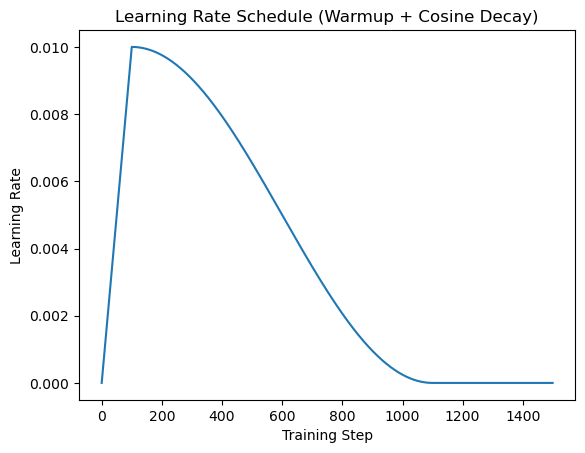

In [ ]:
# Define the learning rate schedule for visualization
warmup_steps = 100
decay_steps = 1000
initial_learning_rate = 0.01

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps
)
final_lr_schedule = WarmupThenCosineDecay(lr_schedule, warmup_steps, initial_learning_rate)

# Learning rates for 15000 steps
learning_rates = [final_lr_schedule(step) for step in range(1500)]

# Plot the learning rate schedule
plt.plot(range(1500), learning_rates)
plt.title("Learning Rate Schedule (Warmup + Cosine Decay)")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
# Make neural network architecture with 2 and 4 hidden layers
model_2_layers = Sequential()
model_2_layers.add(Dense(neurons, input_dim=2, activation='relu'))
model_2_layers.add(Dense(neurons, activation='relu'))
model_2_layers.add(Dense(1, activation='sigmoid'))

model_4_layers = Sequential()
model_4_layers.add(Dense(neurons, input_dim=2, activation='relu'))
model_4_layers.add(Dense(neurons, activation='relu'))
model_4_layers.add(Dense(neurons, activation='relu'))
model_4_layers.add(Dense(neurons, activation='relu'))
model_4_layers.add(Dense(1, activation='sigmoid'))

final_lr_schedule_2 = WarmupThenCosineDecay(lr_schedule, grid_result.best_params_["model__warmup_steps"], grid_result.best_params_['model__lr'])
optimizer_2 = Adam(learning_rate=final_lr_schedule_2)
final_lr_schedule_4 = WarmupThenCosineDecay(lr_schedule, grid_result.best_params_["model__warmup_steps"], grid_result.best_params_['model__lr'])
optimizer_4 = Adam(learning_rate=final_lr_schedule_4)

# Compile the models
model_2_layers.compile(optimizer=optimizer_2, loss='binary_crossentropy', metrics=['accuracy'])
model_4_layers.compile(optimizer=optimizer_4, loss='binary_crossentropy', metrics=['accuracy'])



# Train the models
model_2_layers.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)
model_4_layers.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)

# Evaluate the models
loss_2_layers, accuracy_2_layers = model_2_layers.evaluate(test[['x0', 'x1']], test['y'])
loss_4_layers, accuracy_4_layers = model_4_layers.evaluate(test[['x0', 'x1']], test['y'])

print(f'Accuracy with 2 hidden layers: {accuracy_2_layers:.2f}')
print(f'Accuracy with 4 hidden layers: {accuracy_4_layers:.2f}')

c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9060 - loss: 0.3212
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9240 - loss: 0.2669
Accuracy with 2 hidden layers: 0.91
Accuracy with 4 hidden layers: 0.92


In [ ]:
# Make neural network architecture with 5 and 20 neurons
model_5_neurons = Sequential()
model_5_neurons.add(Dense(5, input_dim=2, activation='relu'))
model_5_neurons.add(Dense(5, activation='relu'))
model_5_neurons.add(Dense(5, activation='relu'))
model_5_neurons.add(Dense(1, activation='sigmoid'))

model_20_neurons = Sequential()
model_20_neurons.add(Dense(20, input_dim=2, activation='relu'))
model_20_neurons.add(Dense(20, activation='relu'))
model_20_neurons.add(Dense(20, activation='relu'))
model_20_neurons.add(Dense(1, activation='sigmoid'))

final_lr_schedule_5 = WarmupThenCosineDecay(lr_schedule, grid_result.best_params_["model__warmup_steps"], grid_result.best_params_['model__lr'])
optimizer_5 = Adam(learning_rate=final_lr_schedule_2)
final_lr_schedule_20 = WarmupThenCosineDecay(lr_schedule, grid_result.best_params_["model__warmup_steps"], grid_result.best_params_['model__lr'])
optimizer_20 = Adam(learning_rate=final_lr_schedule_4)

# Compile the models
model_5_neurons.compile(optimizer=optimizer_5, loss='binary_crossentropy', metrics=['accuracy'])
model_20_neurons.compile(optimizer=optimizer_20, loss='binary_crossentropy', metrics=['accuracy'])

# Train the models
model_5_neurons.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)
model_20_neurons.fit(train[['x0', 'x1']], train['y'], epochs=grid_result.best_params_["epochs"], verbose=0)

# Evaluate the models
loss_5_neurons, accuracy_5_neurons = model_5_neurons.evaluate(test[['x0', 'x1']], test['y'])
loss_20_neurons, accuracy_20_neurons = model_20_neurons.evaluate(test[['x0', 'x1']], test['y'])

print(f'Accuracy 5 neurons: {accuracy_5_neurons:.2f}')
print(f'Accuracy 20 neurons: {accuracy_20_neurons:.2f}')

c:\Users\matis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8940 - loss: 0.3273
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9160 - loss: 0.2684
Accuracy 5 neurons: 0.89
Accuracy 20 neurons: 0.92


# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [101]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [102]:
data_new = pd.read_csv('unsupervised_data.csv')

# Extracting original column names and sorting them based on the numeric value after 'col_'
original_columns = data_new.columns

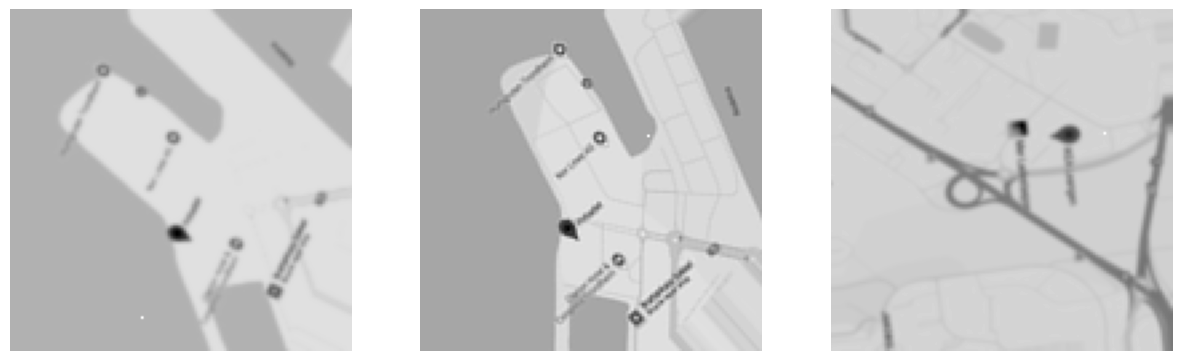

In [103]:
sorted_columns = sorted(original_columns, key=lambda x: int(x.split('_')[1]))

# Reorder the dataframe using the sorted columns
data_sorted = data_new[sorted_columns]

# Reshaping into 128x128 images (16384 pixels per image) and display the first five images
image_data = data_sorted.iloc[:, :128*128].values.reshape(-1, 128, 128)  # reshaping to as many images as the data allows

# Plotting the first 5 images, assuming there are at least 5 images
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
for i in range(3):
    if i < image_data.shape[0]:  # Check if there is enough data to plot
        axes[i].imshow(image_data[i+12], cmap='gray')
        axes[i].axis('off')
plt.show()

In [104]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


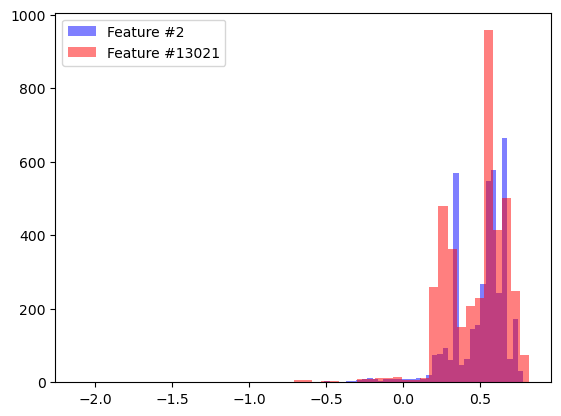

In [105]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

In [106]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


In [126]:

# Reread the data
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data.columns = data.columns.astype(str)

# normalize the data
ids = data['ID'].values
data_scaled = data.drop(columns=['ID']).values
data_scaled.shape

(4000, 16384)

Explained variance: 0.10621860628822294


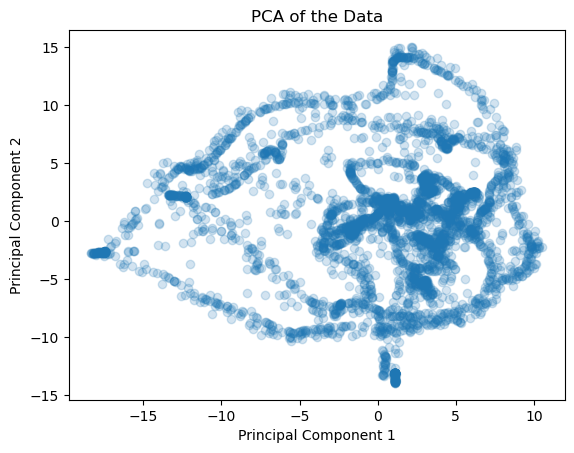

In [127]:
# Apply PCA to reduce the dimensionality of the data

pca = PCA(n_components=2, random_state=seed)
data_pca = pca.fit_transform(data_scaled)

# lost variance
pca.explained_variance_ratio_.sum()
print(f"Explained variance: {pca.explained_variance_ratio_.sum()}")
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of the Data')
plt.show()

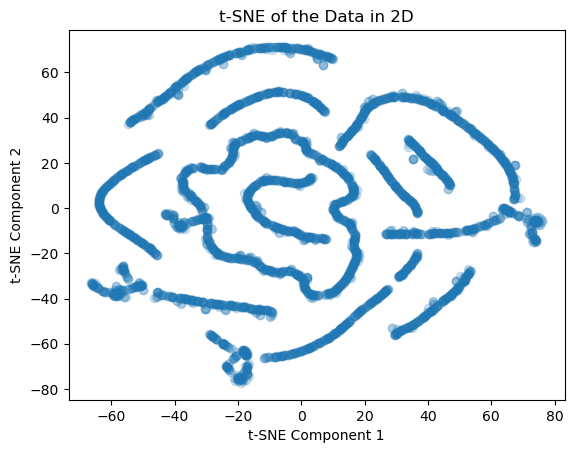

In [128]:
# Applying t-SNE to visualize the data

tsne = TSNE(n_components=2, random_state=seed)
data_tsne = tsne.fit_transform(data_scaled)

plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of the Data in 2D')
plt.show()


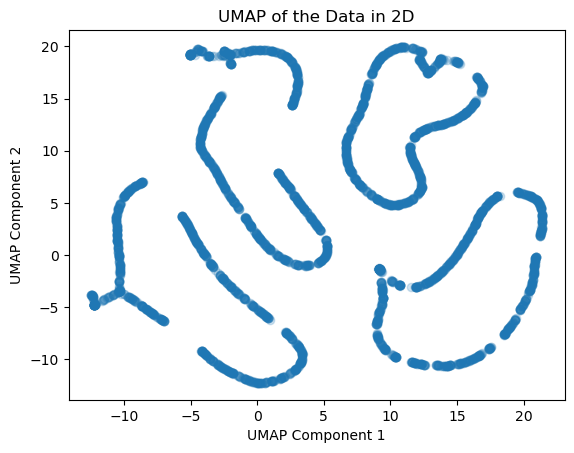

In [129]:
# Applying UMAP to visualize the data

umap = UMAP(n_components=2)
data_umap = umap.fit_transform(data_scaled)

plt.scatter(data_umap[:, 0], data_umap[:, 1], alpha=0.2)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP of the Data in 2D')
plt.show()

In [130]:
# Apply PCA while keeping 99.9% of the variance
pca = PCA(n_components=0.999, random_state=seed)
data_pca_ts = pca.fit_transform(data_scaled)

# lost variance
pca.explained_variance_ratio_.sum()
print(f"Explained variance after PCA: {pca.explained_variance_ratio_.sum()}")

# Print amount of components

Explained variance after PCA: 0.9990022315812312


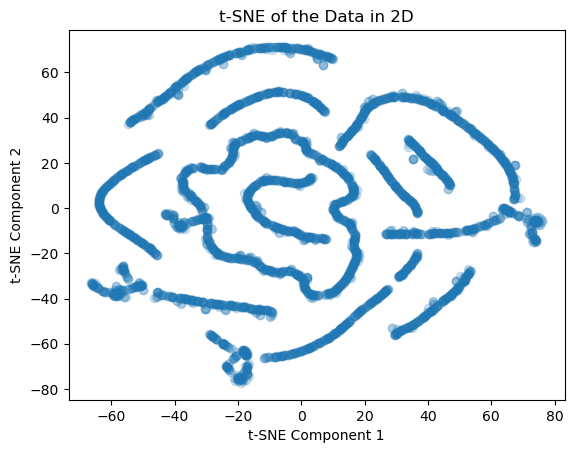

In [131]:
# Applying further t-SNE to visualize the data and visualize the data in 2D

tsne = TSNE(n_components=2, random_state=seed)
data_tsne_pca = tsne.fit_transform(data_pca_ts)

plt.scatter(data_tsne[:, 0], data_tsne[:, 1], alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of the Data in 2D')
plt.show()

In [132]:
# Define the parameter grid for t-SNE
param_grid_tsne = {
    'perplexity': [5, 10, 30, 50],
    'learning_rate': [100, 200, 500],
    'max_iter': [500, 1000]  # You can try a higher number of iterations if needed
}

# Grid search for t-SNE
best_tsne_score = -1
best_tsne_params = None
best_tsne_embedding = None

for params in ParameterGrid(param_grid_tsne):
    # prepare kwargs dynamically
    tsne_kwargs = {
        'perplexity': params['perplexity'],
        'learning_rate': params['learning_rate'],
        'max_iter': params['max_iter'],
        'random_state': 42
    }
    
    tsne = TSNE(**tsne_kwargs)
    tsne_embedding = tsne.fit_transform(data_pca_ts)

    dbscan = DBSCAN()
    labels = dbscan.fit_predict(tsne_embedding)

    if len(set(labels)) > 1 and len(set(labels)) != len(labels):
        score = silhouette_score(tsne_embedding, labels)
        print(f"Params: {params}, Silhouette Score: {score:.4f}")
        if score > best_tsne_score:
            best_tsne_score = score
            best_tsne_params = params
            best_tsne_embedding = tsne_embedding

print(f'Best t-SNE params: {best_tsne_params}')
print(f'Best Silhouette score for t-SNE: {best_tsne_score:.4f}')

Params: {'learning_rate': 100, 'max_iter': 500, 'perplexity': 5}, Silhouette Score: -0.2184
Params: {'learning_rate': 100, 'max_iter': 500, 'perplexity': 10}, Silhouette Score: 0.1784
Params: {'learning_rate': 100, 'max_iter': 500, 'perplexity': 30}, Silhouette Score: 0.4494
Params: {'learning_rate': 100, 'max_iter': 500, 'perplexity': 50}, Silhouette Score: 0.3971
Params: {'learning_rate': 100, 'max_iter': 1000, 'perplexity': 5}, Silhouette Score: -0.7255
Params: {'learning_rate': 100, 'max_iter': 1000, 'perplexity': 10}, Silhouette Score: -0.4324
Params: {'learning_rate': 100, 'max_iter': 1000, 'perplexity': 30}, Silhouette Score: 0.2217
Params: {'learning_rate': 100, 'max_iter': 1000, 'perplexity': 50}, Silhouette Score: 0.3135
Params: {'learning_rate': 200, 'max_iter': 500, 'perplexity': 5}, Silhouette Score: -0.3296
Params: {'learning_rate': 200, 'max_iter': 500, 'perplexity': 10}, Silhouette Score: -0.0008
Params: {'learning_rate': 200, 'max_iter': 500, 'perplexity': 30}, Silhoue

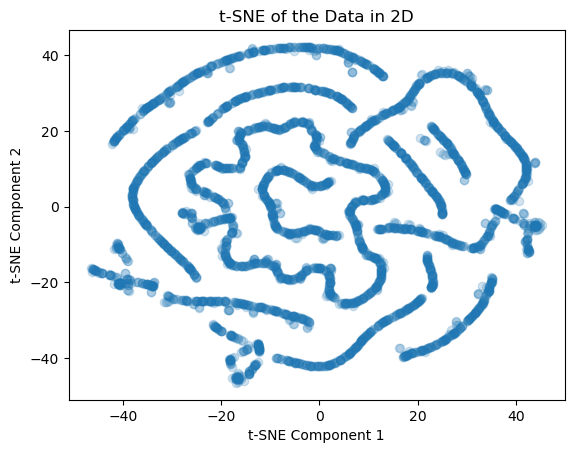

In [133]:
# Add the best t-SNE embedding to the data

tsne = TSNE(n_components=2, random_state=seed, perplexity=best_tsne_params['perplexity'], learning_rate=best_tsne_params['learning_rate'], max_iter=best_tsne_params['max_iter'])
data_tsne_pca_best_params = tsne.fit_transform(data_pca_ts)

# plot the best t-SNE embedding

plt.scatter(data_tsne_pca_best_params[:, 0], data_tsne_pca_best_params[:, 1], alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE of the Data in 2D')
plt.show()

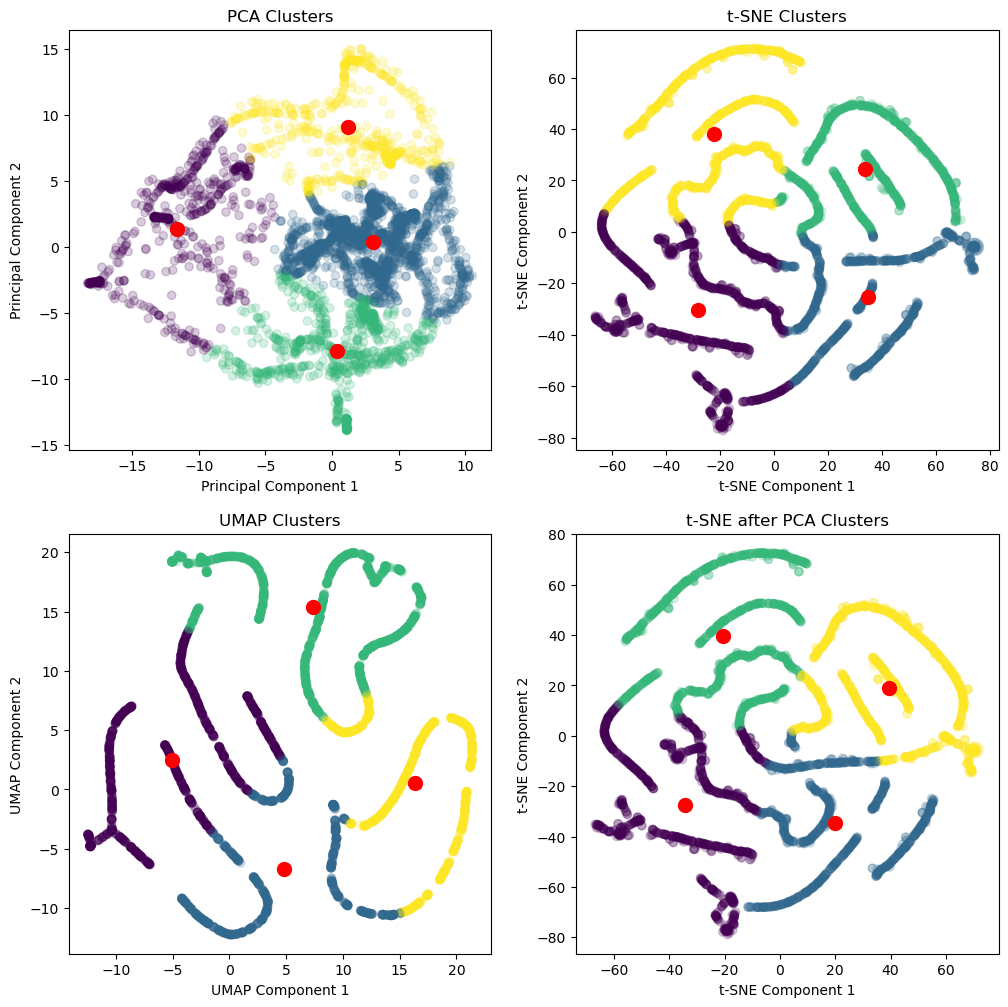

In [134]:
# Applying k-means clustering algorithms

clusters = 4 # we know this from the preprocessing by counting unique pictures

kmeans_pca = KMeans(n_clusters=clusters, random_state=seed)
kmeans_tsne = KMeans(n_clusters=clusters, random_state=seed)
kmeans_umap = KMeans(n_clusters=clusters, random_state=seed)
kmeans_pca_ts = KMeans(n_clusters=clusters, random_state=seed)

# Fit and predict the model
kmeanpredpca = kmeans_pca.fit_predict(data_pca)
kmeanpredtsne = kmeans_tsne.fit_predict(data_tsne)
kmeanpredumap = kmeans_umap.fit_predict(data_umap)
kmeanpredpcats = kmeans_pca_ts.fit_predict(data_tsne_pca)

# Visualize the clusters
plt.figure(figsize=(12, 12))

# PCA
plt.subplot(2, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeanpredpca, alpha=0.2)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clusters')

# t-SNE
plt.subplot(2, 2, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=kmeanpredtsne, alpha=0.2)
plt.scatter(kmeans_tsne.cluster_centers_[:, 0], kmeans_tsne.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Clusters')

# UMAP
plt.subplot(2, 2, 3)
plt.scatter(data_umap[:, 0], data_umap[:, 1], c=kmeanpredumap, alpha=0.2)
plt.scatter(kmeans_umap.cluster_centers_[:, 0], kmeans_umap.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clusters')

# PCA after t-SNE
plt.subplot(2, 2, 4)
plt.scatter(data_tsne_pca[:, 0], data_tsne_pca[:, 1], c=kmeanpredpcats, alpha=0.2)
plt.scatter(kmeans_pca_ts.cluster_centers_[:, 0], kmeans_pca_ts.cluster_centers_[:, 1], c='red', s=100)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE after PCA Clusters')

plt.show()

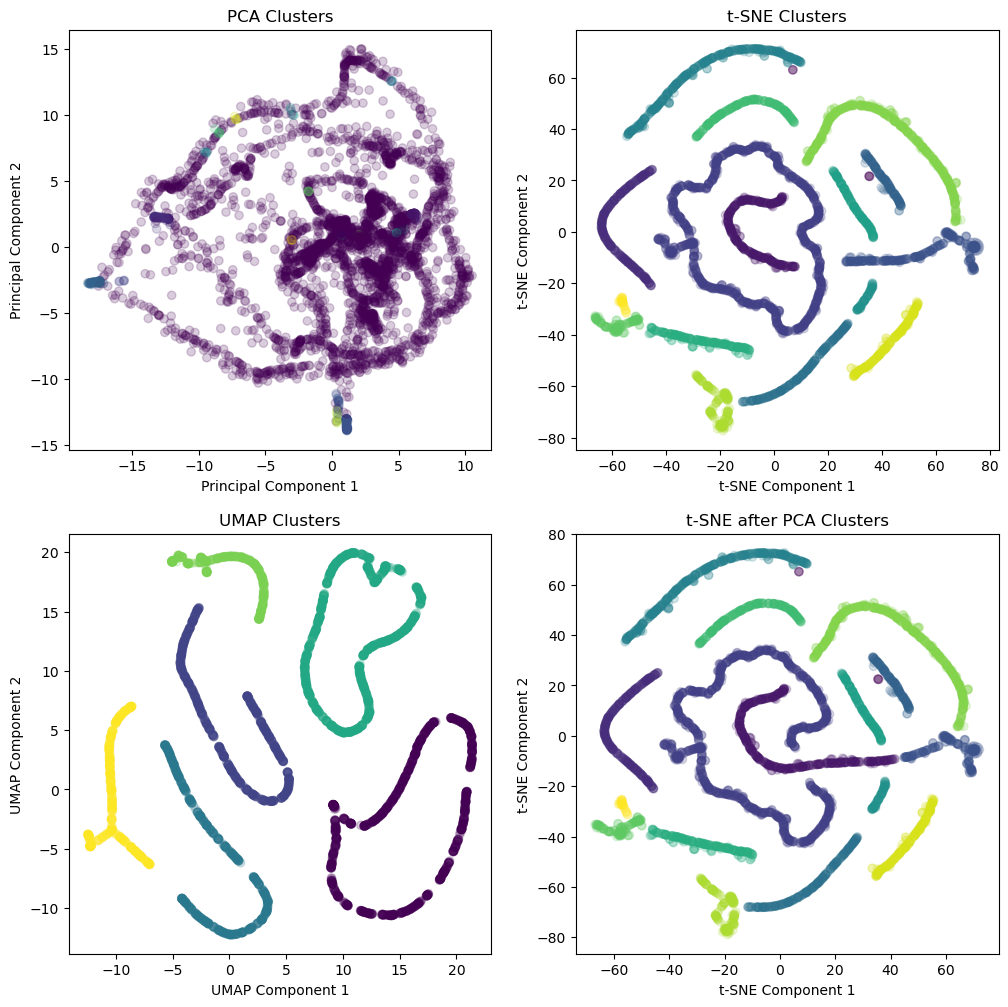

In [ ]:
# Applying DBSCAN clustering algorithms
epss = 3

dbscan_pca = DBSCAN(eps=epss)
dbscan_tsne = DBSCAN(eps=epss)
dbscan_umap = DBSCAN(eps=epss)
dbscan_pca_ts = DBSCAN(eps=epss)

# Fit and predict the model
dbscanpredpca = dbscan_pca.fit_predict(data_pca_ts)
dbscanpredtsne = dbscan_tsne.fit_predict(data_tsne)
dbscanpredumap = dbscan_umap.fit_predict(data_umap)
dbscanpredpcats = dbscan_pca_ts.fit_predict(data_tsne_pca)

# Visualize the clusters
plt.figure(figsize=(12, 12))

# PCA
plt.subplot(2, 2, 1)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscanpredpca, alpha=0.2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Clusters')

# t-SNE
plt.subplot(2, 2, 2)
plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=dbscanpredtsne, alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Clusters')

# UMAP
plt.subplot(2, 2, 3)
plt.scatter(data_umap[:, 0], data_umap[:, 1], c=dbscanpredumap, alpha=0.2)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Clusters')

# PCA after t-SNE
plt.subplot(2, 2, 4)
plt.scatter(data_tsne_pca[:, 0], data_tsne_pca[:, 1], c=dbscanpredpcats, alpha=0.2)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE after PCA Clusters')

plt.show()

In [136]:
# Generate submissions for Kaggle with clustering results

# PCA
submission_pca = pd.DataFrame({'ID': ids, 'cluster': kmeanpredpca})
submission_pca.to_csv('kmeans/submission_pca.csv', index=False)

# t-SNE
submission_tsne = pd.DataFrame({'ID': ids, 'cluster': kmeanpredtsne})
submission_tsne.to_csv('kmeans/submission_tsne.csv', index=False)

# PCA + t-SNE
submission_pca_ts = pd.DataFrame({'ID': ids, 'cluster': kmeanpredpcats})
submission_pca_ts.to_csv('kmeans/submission_pca_ts.csv', index=False)

# UMAP
submission_umap = pd.DataFrame({'ID': ids, 'cluster': kmeanpredumap})
submission_umap.to_csv('kmeans/submission_umap.csv', index=False)

# Random submission
submission_random = pd.DataFrame({'ID': ids, 'cluster': np.random.randint(0, 4, len(ids))})
submission_random.to_csv('kmeans/submission_random.csv', index=False)

In [137]:
# Generate submissions for Kaggle with clustering results

# PCA
submission_pca = pd.DataFrame({'ID': ids, 'cluster': dbscanpredpca})
submission_pca.to_csv('dbscan/submission_pca.csv', index=False)

# t-SNE
submission_tsne = pd.DataFrame({'ID': ids, 'cluster': dbscanpredtsne})
submission_tsne.to_csv('dbscan/submission_tsne.csv', index=False)

# PCA + t-SNE
submission_pca_ts = pd.DataFrame({'ID': ids, 'cluster': dbscanpredpcats})
submission_pca_ts.to_csv('dbscan/submission_pca_ts.csv', index=False)

# UMAP
submission_umap = pd.DataFrame({'ID': ids, 'cluster': dbscanpredumap})
submission_umap.to_csv('dbscan/submission_umap.csv', index=False)

# Random submission
submission_random = pd.DataFrame({'ID': ids, 'cluster': np.random.randint(0, 4, len(ids))})
submission_random.to_csv('dbscan/submission_random.csv', index=False)

Discussion


Dimensionality Reduction Methods

For dimensionality reduction, I selected UMAP as the method of choice, primarily based on empirical performance rather than theoretical reasoning. Below is a brief overview of the three methods explored PCA, t-SNE, and UMAP, followed by an explanation of why UMAP performed best.

Principal Component Analysis (PCA) reduces dimensionality by transforming correlated variables into a smaller set of uncorrelated principal components. It projects the data onto a lower-dimensional space while retaining as much variance as possible, focusing on capturing the global structure of the dataset.

t-distributed Stochastic Neighbor Embedding (t-SNE) is a nonlinear technique that converts high-dimensional relationships into probabilities, where similar points have higher probabilities of being near each other. It then maps these relationships into a lower-dimensional space by minimizing the Kullback Leibler divergence between the high- and low-dimensional distributions. t-SNE excels at revealing local structure but often distorts global relationships.

Uniform Manifold Approximation and Projection (UMAP) is another nonlinear method that uses concepts from manifold learning, topology, and Riemannian geometry. Like t-SNE, it focuses on preserving local relationships but can also retain some global structure depending on its hyperparameters. Conceptually, it can be thought of as sorting Lego bricks grouping similar shapes and sizes (local structure) while still maintaining a sense of the larger overall arrangement (global structure).

In essence, PCA captures global variance, t-SNE emphasizes local neighborhoods, and UMAP strikes a balance between both. This balance likely explains UMAP’s superior performance in this task: the dataset contained global noise where purely local or purely global approaches struggled. UMAP’s ability to adaptively preserve both levels of structure made it the most effective choice.


Clustering Approach

For clustering, I chose DBSCAN, as it produced the best results when applied to the UMAP embedding. The key hyperparameter, eps = 3, was selected empirically based on visual inspection and performance it clearly revealed four distinct clusters that aligned well with the data structure.

K-Means, while a popular choice, did not perform as well in this case. It partitions data into K clusters by initializing K centroids and iteratively assigning each point to the nearest centroid based on Euclidean distance. The centroids are then updated to the mean position of their assigned points until convergence. This approach assumes clusters are roughly spherical and of similar size, which made it less effective for the irregular, non-linearly separable clusters present in this dataset.

In contrast, DBSCAN (Density-Based Spatial Clustering of Applications with Noise) identifies clusters based on the density of points rather than distance to a centroid. It groups points that are closely packed together while labeling isolated points in low-density regions as outliers. This makes DBSCAN particularly effective for datasets with complex shapes and varying densities. Unlike K-Means, it does not require specifying the number of clusters in advance and can naturally discover arbitrarily shaped clusters.

In summary, DBSCAN was better suited for this task because it captured the non-linear, density-based cluster structures revealed by the UMAP embedding, while K-Means struggled to adapt to the data’s irregular geometry.

Server Locations:
* trondheim spektrum
* Ikea Leangen
* Studentersamfundet
* Pirbadet

Data Type Analysis

The “hidden data type” likely referred to the initially skipped row that revealed the feature ordering for the image data. By reordering these features correctly, I was able to reconstruct the original images and visually identify the locations of the clusters.

In theory, the order of columns should not influence clustering or dimensionality reduction results, as these algorithms operate on the underlying relationships between features rather than their sequence. However, this discovery clarified that each data point represents a pixel, making the problem inherently spatial.

This insight explains why UMAP performed particularly well, it groups similar pixels together while preserving aspects of the global image structure. PCA, on the other hand, focuses on capturing global variance and is less effective when local spatial relationships (like neighboring pixels) carry the key information, especially under image noise or rotation. t-SNE likely overemphasized local structures, capturing fine-grained pixel similarities but losing the broader image context.

In summary, understanding the data as image-based and spatially dependent helped explain why UMAP achieved the best clustering performance.


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [138]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [139]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

1.0

In [140]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.3333333333333333

In [141]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

0.5